# Process Data

## Load Data

In [3]:
import pandas as pd

PATH = '../Twitter_Climate_Change_Dataset/twitter_sentiment_data.csv'
df = pd.read_csv(PATH)
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


Seperate Messages from the rest of the data, for NLP

In [4]:
dfMessages = df['message']

## Plot Data

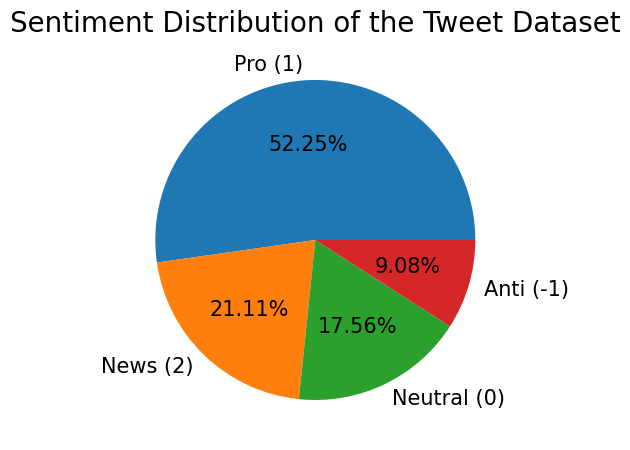

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize = (5, 5))
plt.pie(df.sentiment.value_counts().values, labels = ['Pro (1)', 'News (2)', 'Neutral (0)', 'Anti (-1)'], autopct = '%.2f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()

# Pre-Processing

## Data Cleaning

In [ ]:
def removeTwitterContent(text):
    '''
    Clean the Text of ReTweet-symbols and usernames
    '''

In [ ]:
def removeStopwordsPunctuation(text):
    '''
    Clean the text of Stopwords and punctuation
    '''

In [ ]:
def lemmatizeWords(text):
    '''
    Lemmatize the text that is put in
    '''

In [ ]:
import wordnet

def negations (sentence):
    '''
    Turn negated words into cognitive synonyms. (Source: https://gist.github.com/UtkarshRedd/3fbfd354ea7a6f83bd8f9419a27b0543#file-negation_handler-py)
    '''
    temp = int(0)
    for i in range(len(sentence)):
        if sentence[i-1] in ['not',"n't"]:
            antonyms = []
            for syn in wordnet.synsets(sentence[i]):
                syns = wordnet.synsets(sentence[i])
                w1 = syns[0].name()
                temp = 0
                for l in syn.lemmas():
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                for ant in antonyms:
                    syns = wordnet.synsets(ant)
                    w2 = syns[0].name()
                    syns = wordnet.synsets(sentence[i])
                    w1 = syns[0].name()
                    word1 = wordnet.synset(w1)
                    word2 = wordnet.synset(w2)
                    if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
                        temp = 1 - word1.wup_similarity(word2)
                    if temp>max_dissimilarity:
                        max_dissimilarity = temp
                        antonym_max = ant
                        sentence[i] = antonym_max
                        sentence[i-1] = ''
    while '' in sentence:
        sentence.remove('')
    return sentence

## Tokenization

In [6]:
from nltk.tokenize import word_tokenize

def wordTokens (text):
    '''
    Create a list of lower-cased words
    '''
    text = text.lower()
    tokenized_word = word_tokenize(text)
    return tokenized_word

In [7]:
tokenized_messages = []
for message in dfMessages:
    tokenized_message = wordTokens(message)
    tokenized_messages.append(tokenized_message)
print(tokenized_messages[3])

['rt', '@', 'mick_fanning', ':', 'just', 'watched', 'this', 'amazing', 'documentary', 'by', 'leonardodicaprio', 'on', 'climate', 'change', '.', 'we', 'all', 'think', 'thisã¢â‚¬â¦', 'https', ':', '//t.co/knste8k8im']


In [ ]:
def bigrams (text):
    '''
    Tokenize texts as bigrams. Not Higher because it causes very
    sparse feature vectors.
    '''

### Data Plots

In [8]:
import itertools

joined_tokens = list(itertools.chain.from_iterable(tokenized_messages))

<Axes: title={'center': 'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='frequency', ylabel='word'>

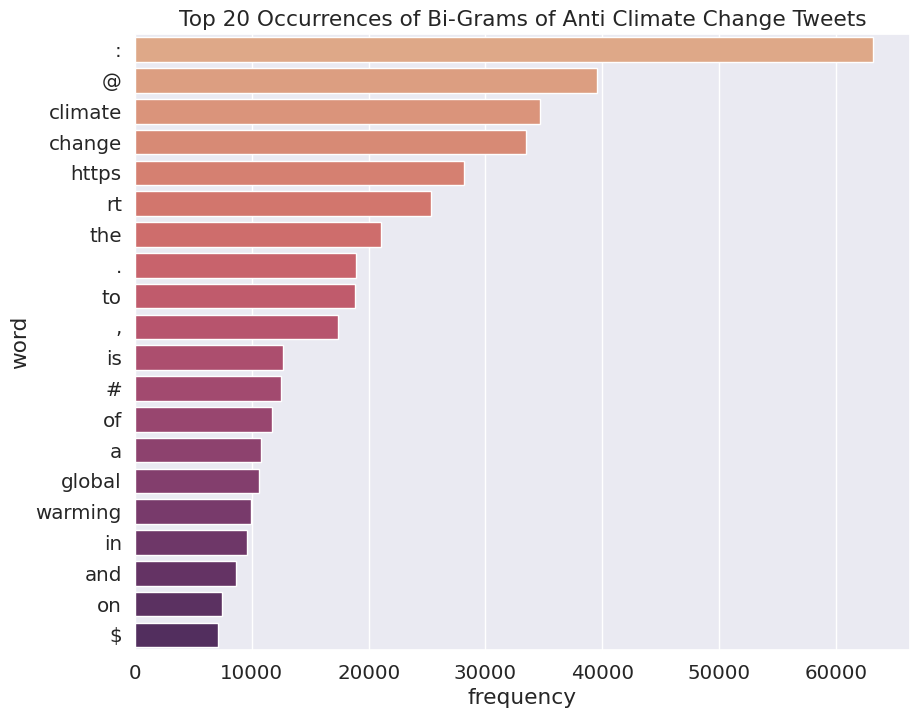

In [19]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fdist = FreqDist(joined_tokens)
df_fdist = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])
# fdist.plot(30,cumulative=False)
# plt.show()
df_fdist.head()
sns.set(font_scale = 1.3)
plt.figure(figsize=(10, 8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="frequency", y="word", data=df_fdist.sort_values('frequency', ascending=False).head(20), palette="flare")

# Vectorize Tokens

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
sentences = []
for tweet in tokenized_messages:

    sentence  = ' '.join(tweet)
    sentences.append(sentence)
cv = CountVectorizer(binary=True)
print(sentences[9])
cv.fit(sentences)
vectorizedMessages = cv.transform(sentences)

# beforetheflood watch # beforetheflood right here , as @ leodicaprio travels the world to tackle climate change ... https : //t.co/hcizrpuhlf


# Model Development

In [35]:
from sklearn import metrics

def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

### Split Dataset

In [32]:
from sklearn.model_selection import train_test_split

target = df['sentiment']
X = vectorizedMessages

X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
clfModel = model.fit(X_train, y_train)
clsScoreDict = evaluateModel(clfModel, X_test, y_test, 'LogisticRegression')


*** LogisticRegression ***
Accuracy:  0.740123793919534
Precision: 0.7362025847429119
Recall:    0.740123793919534
F1:        0.7353891870356344





/home/freddy/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Naive Bayes Classifier

# Model Evaluation